# Trend Analysis 4 – Expanded Insights

**Author:** Abin Baby  
**Date:** 08-08-2025  
**Branch:** feature/trend-analysis

This notebook extends the work from **TrendAnalysis 3** by adding:
- **Per-Product Summary Table**: Showing total sales, average price, and sale frequency for each SKU.
- **Public Holiday Proximity Analysis**: Flagging sales that occur within X days of public holidays.
- **Next Sale Prediction**: Predicting the likely next sale date for each SKU using historical intervals.
- **Visual Enhancements**: Updated trend plots and optional backtesting.

These additions aim to provide deeper insights for the Data Analysis team’s contribution to **DiscountMate** and support integration into Looker Studio for stakeholders.

## Dataset Information

This notebook uses the same base dataset as TrendAnalysis 3:
- **File**: AugmentedData.product_pricing.csv
- **Columns**:
    - Date: Date of transaction
    - SKU: Stock Keeping Unit identifier
    - unit_price: Price per unit
    - units_sold: Number of units sold
    - Additional engineered features from previous notebooks

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re

# CONFIG
DATA_PATH = "AugmentedData.product_pricing.csv"
OUTPUT_DIR = Path("Data Analysis/outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

SUMMARY_CSV = OUTPUT_DIR / "product_sale_summary.csv"
PREDICTIONS_CSV = OUTPUT_DIR / "product_next_sale_predictions.csv"

# DISPLAY
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)
sns.set_style("whitegrid")

# 1) LOAD
df = pd.read_csv(DATA_PATH)
print("Columns found:", df.columns.tolist())

# 2) AUTO-DETECT CORE COLUMNS
cols_lower = [c.lower() for c in df.columns]

def pick(candidates, required=True):
    for cand in candidates:
        if cand in cols_lower:
            return df.columns[cols_lower.index(cand)]
    if required:
        raise ValueError(f"Could not find any of {candidates} in columns {df.columns.tolist()}")
    return None

date_col  = pick(["date","datetime","timestamp","transaction_date","sale_date"])
price_col = pick(["unit_price","price","sale_price","regular_price"])
sku_col   = pick(["sku","product_id","product","item_id","productcode"])
units_col = pick(["units_sold","quantity","qty","units","sales_qty"], required=False)

print("Detected -> date:", date_col, "| price:", price_col, "| sku:", sku_col, "| units:", units_col)

# 3) TYPE CLEANUP 
raw_date = df[date_col].astype(str).str.strip()

# If values look like MM:SS(.s), treat as durations; else parse as datetimes.
dur_pat = r"^\d{1,2}:\d{2}(?:\.\d+)?$"
if raw_date.str.match(dur_pat).all():
    # Duration: prepend hours so 35:24.5 -> 00:35:24.5
    df[date_col] = pd.to_timedelta("00:" + raw_date, errors="coerce")
else:
    # Datetime: parse as real date
    df[date_col] = pd.to_datetime(raw_date, errors="coerce")

df[price_col] = pd.to_numeric(df[price_col], errors="coerce")
if units_col:
    df[units_col] = pd.to_numeric(df[units_col], errors="coerce")

# Dropping unusable rows & sorting
need_cols = [date_col, price_col, sku_col]
df = df.dropna(subset=need_cols).sort_values([sku_col, date_col]).reset_index(drop=True)

print("Rows after cleaning:", len(df))
display(df.head())

# Build holidays dynamically if we have real dates
if pd.api.types.is_datetime64_any_dtype(df[date_col]):
    years_in_data = df[date_col].dt.year.unique()
    base_holidays = {
        "New Year’s Day": (1, 1),
        "ANZAC Day": (4, 25),
        "King’s Birthday (VIC)": (6, 9),  # approx; varies by year
        "EOFY": (6, 30),
        "Christmas Day": (12, 25),
        "Boxing Day": (12, 26),
        # placeholders — can compute correctly if you want:
        "Good Friday": (4, 18),
        "Easter Monday": (4, 21),
    }
    HOLIDAYS = {
        f"{name} {y}": pd.Timestamp(year=y, month=m, day=d)
        for y in years_in_data
        for name, (m, d) in base_holidays.items()
    }
    HOLIDAY_WINDOW_DAYS = 7
    print(f"Dynamic holidays created for years: {sorted(years_in_data.tolist())}")
else:
    HOLIDAYS = {}
    HOLIDAY_WINDOW_DAYS = 7
    print("Note: date column is a duration (Timedelta). Holiday proximity will be NaN.")

Columns found: ['_id', 'product_id', 'date', 'price']
Detected -> date: date | price: price | sku: product_id | units: None
Rows after cleaning: 612


,_id,product_id,date,price
0,cf878c81-b0f3-4c9d-bb86-6cd201c4608f,1f59c631-ca0d-47d9-aac2-8da2dbc1f134,0 days 00:35:53.200000,97.48
1,ad16099d-dbd4-47d0-a936-d1a1115bd993,1f59c631-ca0d-47d9-aac2-8da2dbc1f134,0 days 00:37:44.600000,95.99
2,79ff9584-487f-4824-893f-0a30c1464222,1f59c631-ca0d-47d9-aac2-8da2dbc1f134,0 days 00:38:58.500000,69.30
3,a145a6b5-058a-421b-a911-fa14e94dd6bc,1f59c631-ca0d-47d9-aac2-8da2dbc1f134,0 days 00:39:13.800000,85.38
4,d6a6a566-df8d-4790-91c0-51c125d85d0d,1f59c631-ca0d-47d9-aac2-8da2dbc1f134,0 days 00:39:13.800000,65.63


Note: date column is a duration (Timedelta). Holiday proximity will be NaN.


In [73]:
# 4) HELPERS — safe for datetime or duration (Timedelta)
def nearest_holiday_days(d, holidays: dict) -> float:
    """
    Return absolute days to the nearest holiday date.
    If `d` is a duration (Timedelta) or invalid, return NaN.
    """
    if pd.isna(d) or not holidays:
        return np.nan
    if isinstance(d, pd.Timedelta):
        return np.nan  # holidays don't apply to durations
    d = pd.to_datetime(d, errors="coerce")
    if pd.isna(d):
        return np.nan
    try:
        return float(min(abs((d - h)).days for h in holidays.values()))
    except Exception:
        return np.nan

def _gap_days(series: pd.Series) -> pd.Series:
    """Gap between events in days (float), works for datetime or timedelta series."""
    if pd.api.types.is_timedelta64_dtype(series):
        return series.diff().dt.total_seconds() / 86400.0
    else:
        # datetime64[ns] or coercible
        return pd.to_datetime(series).diff().dt.days.astype("float")

def summarize_product(group: pd.DataFrame,
                      date_col: str,
                      price_col: str,
                      holidays: dict,
                      window_days: int = 7) -> pd.Series:
    """
    For a single product group:
      - Identify 'sales' as price drops
      - Compute gaps between sales + predict next sale
      - Compute % of sales near holidays (NaN for durations)
    Returns a summary row.
    """
    g = group.sort_values(date_col).copy()

    # Sales = price drops
    g["price_diff"] = g[price_col].diff()
    sales = g[g["price_diff"] < 0].copy()
    n_sales = len(sales)
    last_sale = sales[date_col].max() if n_sales else pd.NaT

    # Gaps between sales (days, float)
    if n_sales >= 2:
        gaps = _gap_days(sales[date_col]).dropna()
        avg_gap = float(gaps.mean()) if len(gaps) else np.nan
        med_gap = float(gaps.median()) if len(gaps) else np.nan
        gap_days = med_gap if pd.notna(med_gap) else avg_gap
        predicted_next_sale = (
            last_sale + pd.to_timedelta(float(gap_days), unit="D")
            if pd.notna(last_sale) and pd.notna(gap_days) else pd.NaT
        )
    else:
        avg_gap = med_gap = np.nan
        predicted_next_sale = pd.NaT

    # Holiday proximity (only meaningful for real calendar dates)
    if n_sales and not pd.api.types.is_timedelta64_dtype(sales[date_col]):
        sales["days_to_nearest_holiday"] = sales[date_col].apply(
            lambda d: nearest_holiday_days(d, holidays)
        )
        pct_near_holiday = (
            (sales["days_to_nearest_holiday"] <= window_days).mean() * 100
        )
    else:
        pct_near_holiday = np.nan

    out = {
        "n_sales": n_sales,
        "last_sale_date": last_sale,
        "avg_gap_days": avg_gap,
        "median_gap_days": med_gap,
        "predicted_next_sale": predicted_next_sale,
        "pct_sales_near_holiday": pct_near_holiday,
        "avg_unit_price": g[price_col].mean(),
        "min_unit_price": g[price_col].min(),
        "max_unit_price": g[price_col].max(),
    }

    # Optional units summary if available in outer scope
    if 'units_col' in globals() and units_col:
        out.update({
            "total_units_sold": g[units_col].sum(),
            "avg_units_per_txn": g[units_col].mean(),
        })

    return pd.Series(out)


In [74]:
# 5) SINGLE-PRODUCT DEMO (most common product by rows)
most_common_prod = df[sku_col].value_counts().idxmax()
one = df[df[sku_col] == most_common_prod].copy().sort_values(date_col)

# Identify sale events (price drops)
one["price_diff"] = one[price_col].diff()
sales_one = one[one["price_diff"] < 0].copy()

# Predict next sale time/date for this product
if not sales_one.empty and sales_one[date_col].nunique() >= 2:
    # Choose the right gap calculation depending on dtype
    if pd.api.types.is_timedelta64_dtype(sales_one[date_col]):
        gaps = sales_one[date_col].diff().dt.total_seconds().div(86400.0).dropna()  # days (float)
    else:
        gaps = sales_one[date_col].diff().dt.days.dropna()  # days (int -> float below)

    gap = gaps.median() if pd.notna(gaps.median()) else gaps.mean()
    last_sale_value = sales_one[date_col].max()
    predicted_next = last_sale_value + pd.to_timedelta(float(gap), unit="D") if pd.notna(gap) else pd.NaT

    # Pretty print depending on dtype
    if pd.api.types.is_datetime64_any_dtype(sales_one[date_col]):
        pretty = predicted_next.date() if pd.notna(predicted_next) else "NaT"
        label = "date"
    else:
        # Timedelta: show as HH:MM:SS 
        pretty = str(predicted_next) if pd.notna(predicted_next) else "NaT"
        label = "offset"

    print(f"[{most_common_prod}] Predicted next sale {label} (gap≈{float(gap):.2f} days): {pretty}")
else:
    predicted_next = pd.NaT
    print(f"[{most_common_prod}] Not enough sale events to estimate a next sale.")

# Sales near holidays for this product (safe: nearest_holiday_days handles Timedelta -> NaN)
if not sales_one.empty:
    sales_one["days_to_nearest_holiday"] = sales_one[date_col].apply(
        lambda d: nearest_holiday_days(d, HOLIDAYS)
    )
    sales_one["near_holiday"] = sales_one["days_to_nearest_holiday"] <= HOLIDAY_WINDOW_DAYS
    near_count = int(sales_one["near_holiday"].sum())
    total_sales = len(sales_one)
    pct = (near_count / total_sales) * 100 if total_sales else 0
    print(f"[{most_common_prod}] {near_count}/{total_sales} sales "
          f"({pct:.1f}%) within ±{HOLIDAY_WINDOW_DAYS} days of a holiday.")


[560b49be-32ad-4267-97da-21148ccce35e] Predicted next sale offset (gap≈0.00 days): 0 days 00:40:08.600000
[560b49be-32ad-4267-97da-21148ccce35e] 0/11 sales (0.0%) within ±7 days of a holiday.


In [75]:
# 6) MULTI-PRODUCT SUMMARY 
_used_cols = [date_col, price_col] + ([units_col] if units_col else [])

summary = (
    df[[sku_col] + _used_cols]                        
      .groupby(sku_col, group_keys=False)[_used_cols] 
      .apply(
          summarize_product,
          date_col=date_col,
          price_col=price_col,
          holidays=HOLIDAYS,
          window_days=HOLIDAY_WINDOW_DAYS
      )
      .reset_index()
      .rename(columns={sku_col: "product_id"})
      .sort_values(["n_sales", "pct_sales_near_holiday"], ascending=[False, False])
      .reset_index(drop=True)
)

print("Summary preview:")
display(summary.head(10))

summary.to_csv(SUMMARY_CSV, index=False)
print(f"Saved summary -> {SUMMARY_CSV}")


Summary preview:


,product_id,n_sales,last_sale_date,avg_gap_days,median_gap_days,predicted_next_sale,pct_sales_near_holiday,avg_unit_price,min_unit_price,max_unit_price
0,3b3e2c46-9899-4f14-8f8f-74ec3a1d31a7,13,0 days 00:24:50.100000,0.000180,0.0,0 days 00:24:50.100000,NaN,85.006207,35.99,97.66
1,9e6663e2-5f4d-43c6-ab9a-39ea51aaa01e,12,0 days 00:40:40,0.000081,0.0,0 days 00:40:40,NaN,67.525000,58.54,99.40
2,c45dea72-ab78-4e47-a519-30040f767ac4,12,0 days 00:37:42.300000,0.000105,0.0,0 days 00:37:42.300000,NaN,12.442143,1.71,67.01
3,4ae84bdf-f3a5-45ef-817b-d2a69204a251,11,0 days 00:25:20.400000,0.000000,0.0,0 days 00:25:20.400000,NaN,46.597857,12.78,73.11
4,560b49be-32ad-4267-97da-21148ccce35e,11,0 days 00:40:08.600000,0.000222,0.0,0 days 00:40:08.600000,NaN,54.547667,22.44,95.70
5,ca79f7e0-b57e-471e-962e-6bd2c77eac2f,11,0 days 00:37:22.200000,0.000000,0.0,0 days 00:37:22.200000,NaN,10.944400,5.52,15.76
6,1f59c631-ca0d-47d9-aac2-8da2dbc1f134,10,0 days 00:39:13.800000,0.000115,0.0,0 days 00:39:13.800000,NaN,68.489643,57.74,97.48
7,feaf28a3-4c63-40e2-9b33-a5a00273f91b,10,0 days 00:39:57.200000,0.000000,0.0,0 days 00:39:57.200000,NaN,71.675769,59.13,88.79
8,7a4fb5ec-2e60-429c-a284-a688a7f07387,9,0 days 00:24:17.500000,0.000000,0.0,0 days 00:24:17.500000,NaN,7.210000,0.50,35.37
9,c9561ba4-fd95-4d02-8c09-f50ce8ae88a5,9,0 days 00:24:27.800000,0.000000,0.0,0 days 00:24:27.800000,NaN,38.437692,31.44,83.71


Saved summary -> Data Analysis\outputs\product_sale_summary.csv


In [76]:
# 7) NEXT-SALE PREDICTIONS TABLE (all products) 
pred_rows = []
for pid, g in df.groupby(sku_col):
    g = g.sort_values(date_col).copy()
    g["price_diff"] = g[price_col].diff()
    sales = g[g["price_diff"] < 0]
    if len(sales) >= 2:
        gaps = sales[date_col].diff().dt.days.dropna()
        gap = gaps.median() if pd.notna(gaps.median()) else gaps.mean()
        last_sale = sales[date_col].max()
        next_sale = last_sale + pd.Timedelta(days=float(gap))
        avg_gap = gaps.mean()
        med_gap = gaps.median()
    else:
        gap = np.nan
        last_sale = pd.NaT
        next_sale = pd.NaT
        avg_gap = np.nan
        med_gap = np.nan

    pred_rows.append({
        "product_id": pid,
        "last_sale_date": last_sale,
        "avg_gap_days": avg_gap,
        "median_gap_days": med_gap,
        "predicted_next_sale": next_sale
    })

predictions_df = pd.DataFrame(pred_rows).sort_values("predicted_next_sale")
display(predictions_df.head(10))

predictions_df.to_csv(PREDICTIONS_CSV, index=False)
print(f"Saved predictions -> {PREDICTIONS_CSV}")


,product_id,last_sale_date,avg_gap_days,median_gap_days,predicted_next_sale
4,54725161-52ca-4b2e-8df7-0dcd9d427adf,0 days 00:21:13.600000,0.0,0.0,0 days 00:21:13.600000
16,d5ac2313-6903-4760-9da2-1eaf663387e4,0 days 00:21:23.700000,0.0,0.0,0 days 00:21:23.700000
6,5875ebb3-bba7-4356-bb0e-9f3c7679c975,0 days 00:22:09.400000,0.0,0.0,0 days 00:22:09.400000
17,d7320e1a-eacb-4858-bd84-ef191945c0d7,0 days 00:22:38.500000,0.0,0.0,0 days 00:22:38.500000
7,5fdf1c13-c0b2-44d8-b073-2cc4384a802f,0 days 00:22:41.800000,0.0,0.0,0 days 00:22:41.800000
11,b9935dad-617a-4bf2-9dff-5f01faf98355,0 days 00:22:47.500000,0.0,0.0,0 days 00:22:47.500000
8,7a4fb5ec-2e60-429c-a284-a688a7f07387,0 days 00:24:17.500000,0.0,0.0,0 days 00:24:17.500000
14,c9561ba4-fd95-4d02-8c09-f50ce8ae88a5,0 days 00:24:27.800000,0.0,0.0,0 days 00:24:27.800000
9,9a628005-f452-4c0b-b22e-6c3e61e8a141,0 days 00:24:30,0.0,0.0,0 days 00:24:30
1,3b3e2c46-9899-4f14-8f8f-74ec3a1d31a7,0 days 00:24:50.100000,0.0,0.0,0 days 00:24:50.100000


Saved predictions -> Data Analysis\outputs\product_next_sale_predictions.csv


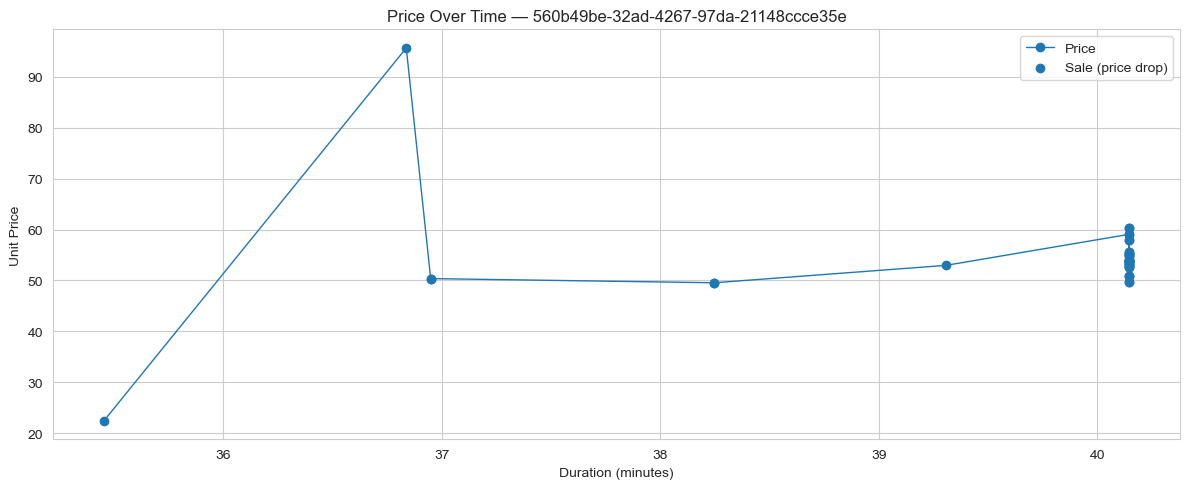

No products have sales within ±7 days of a holiday (date column is a duration, so holiday proximity doesn’t apply).


In [77]:
# 8) VISUALS 
# A) Price over time for most common product

# Decide how to plot x-axis
is_td = pd.api.types.is_timedelta64_dtype(one[date_col])

if is_td:
    x_one   = one[date_col].dt.total_seconds() / 60.0        # minutes
    x_sales = sales_one[date_col].dt.total_seconds() / 60.0 if not sales_one.empty else pd.Series([], dtype=float)
    x_label = "Duration (minutes)"
else:
    x_one   = one[date_col]
    x_sales = sales_one[date_col] if not sales_one.empty else pd.Series([], dtype="datetime64[ns]")
    x_label = "Date"

plt.figure(figsize=(12, 5))
plt.plot(x_one, one[price_col], label="Price", marker="o", linewidth=1)
if not sales_one.empty:
    plt.scatter(x_sales, sales_one[price_col], label="Sale (price drop)", zorder=3)
plt.title(f"Price Over Time — {most_common_prod}")
plt.xlabel(x_label)
plt.ylabel("Unit Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# B) Top 10 products by % of sales near holidays 
valid_holiday_data = summary.dropna(subset=["pct_sales_near_holiday"])
valid_holiday_data = valid_holiday_data[valid_holiday_data["pct_sales_near_holiday"] > 0]

if valid_holiday_data.empty:
    print(f"No products have sales within ±{HOLIDAY_WINDOW_DAYS} days of a holiday "
          f"(date column is a duration, so holiday proximity doesn’t apply).")
else:
    top_holiday = valid_holiday_data.nlargest(10, "pct_sales_near_holiday")
    plt.figure(figsize=(12,5))
    plt.bar(top_holiday["product_id"].astype(str), top_holiday["pct_sales_near_holiday"], edgecolor="black")
    plt.title(f"Top {len(top_holiday)} Products — % Sales Within ±{HOLIDAY_WINDOW_DAYS} Days of Holidays")
    plt.ylabel("% of Sales Near Holidays")
    plt.xlabel("Product")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()




In [78]:
#  9) SIMPLE BACKTEST (optional sanity check on the gap rule)
# Backtest only for the most common product (quick check)
sales_dates = sales_one[date_col].sort_values().tolist() if not sales_one.empty else []
if len(sales_dates) >= 4:
    preds = []
    actuals = []
    # start after we have at least 3 sales to estimate a gap
    for i in range(3, len(sales_dates)-1):
        history = pd.Series(sales_dates[:i]).sort_values()
        gaps = history.diff().dt.days.dropna()
        if gaps.empty:
            continue
        gap_est = gaps.median() if pd.notna(gaps.median()) else gaps.mean()
        pred_next = history.iloc[-1] + pd.Timedelta(days=float(gap_est))
        actual_next = sales_dates[i]  # next observed sale date
        preds.append(pred_next)
        actuals.append(actual_next)

    if preds:
        errors = [(a - p).days for p, a in zip(preds, actuals)]
        mae = np.mean(np.abs(errors))
        print(f"[Backtest] MAE (days) using rolling median-gap rule: {mae:.2f}")
    else:
        print("[Backtest] Not enough rolling windows to evaluate.")
else:
    print("[Backtest] Not enough sale events to perform a simple backtest.")


[Backtest] MAE (days) using rolling median-gap rule: 0.00
